<div align="center">
    <h1>Project - Time Series Multi-Horizon Forecasting using Transformers - DATA931  </h1>
    <h2>Ikram IDDOUCH - Sami SBAI </h2>
    
[![Python](https://img.shields.io/badge/python-blue.svg)](https://shields.io/)
[![VisualStudioCode](https://img.shields.io/badge/VisualStudioCode-green.svg)](https://shields.io/)
</div>

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats

%matplotlib inline

In [10]:
df = pd.read_csv('Data/SP500_features.csv')
df.describe()

,Close,High,Low,Open,Volume,Return_1,LogReturn_1,Momentum_5,Momentum_10,Momentum_20,...,BB_Lower,H-L,H-PC,L-PC,TrueRange,ATR_14,Volatility_20,Volume_SMA20,Volume_Normalized,OBV
count,6523.000000,6523.000000,6523.000000,6523.000000,6.523000e+03,6522.000000,6522.000000,6518.000000,6513.000000,6503.000000,...,6504.000000,6523.000000,6522.000000,6522.000000,6523.000000,6510.000000,6503.000000,6.504000e+03,6504.000000,6.523000e+03
mean,2257.699348,2270.260022,2243.456169,2257.359010,3.415740e+09,0.000312,0.000237,0.001515,0.002962,0.005902,...,2179.522767,26.803853,15.431581,15.909229,29.072967,29.038277,0.010306,3.417129e+09,1.004588,6.049459e+11
std,1438.039990,1444.420078,1430.535554,1437.750038,1.512544e+09,0.012210,0.012226,0.024674,0.033255,0.046204,...,1386.186580,25.599153,20.940949,23.390439,29.336244,24.340132,0.006708,1.377976e+09,0.176848,4.998950e+11
min,676.530029,695.270020,666.789978,679.280029,0.000000e+00,-0.119841,-0.127652,-0.183401,-0.258846,-0.309439,...,646.037851,2.900024,0.000000,0.000000,2.900024,6.681431,0.002072,8.532350e+08,0.000000,-6.867333e+10
25%,1210.079956,1216.119995,1201.350037,1209.840027,2.307400e+09,-0.004737,-0.004748,-0.009974,-0.012811,-0.016603,...,1171.180155,11.750000,3.562531,3.242493,12.150024,13.947298,0.006151,2.434431e+09,0.905585,8.438372e+10
50%,1523.859985,1530.890015,1516.150024,1522.969971,3.527370e+09,0.000642,0.000642,0.003155,0.006392,0.012097,...,1489.314447,18.489990,8.854980,8.620056,19.400024,19.517508,0.008646,3.610034e+09,0.991239,6.076755e+11
75%,2882.000000,2894.179932,2866.959961,2883.649902,4.256600e+09,0.005892,0.005875,0.014628,0.021272,0.032465,...,2790.680276,32.405029,18.877411,18.927429,34.809814,35.856947,0.012459,4.164553e+09,1.088758,1.025827e+12
max,6890.890137,6920.339844,6870.729980,6910.950195,1.145623e+10,0.115800,0.109572,0.191112,0.216384,0.234949,...,6668.829073,532.909668,498.569824,341.629883,532.909668,238.497140,0.061182,7.701906e+09,2.093563,1.588444e+12


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523 entries, 0 to 6522
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               6523 non-null   object 
 1   Close              6523 non-null   float64
 2   High               6523 non-null   float64
 3   Low                6523 non-null   float64
 4   Open               6523 non-null   float64
 5   Volume             6523 non-null   int64  
 6   Return_1           6522 non-null   float64
 7   LogReturn_1        6522 non-null   float64
 8   Momentum_5         6518 non-null   float64
 9   Momentum_10        6513 non-null   float64
 10  Momentum_20        6503 non-null   float64
 11  RSI_14             6509 non-null   float64
 12  EMA_12             6523 non-null   float64
 13  EMA_26             6523 non-null   float64
 14  MACD               6523 non-null   float64
 15  MACD_signal        6523 non-null   float64
 16  BB_Mid             6504 

In [12]:
duplicates = df.duplicated()
print(duplicates.sum())

0


In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

---
## Data Exploration

<Axes: xlabel='Date'>

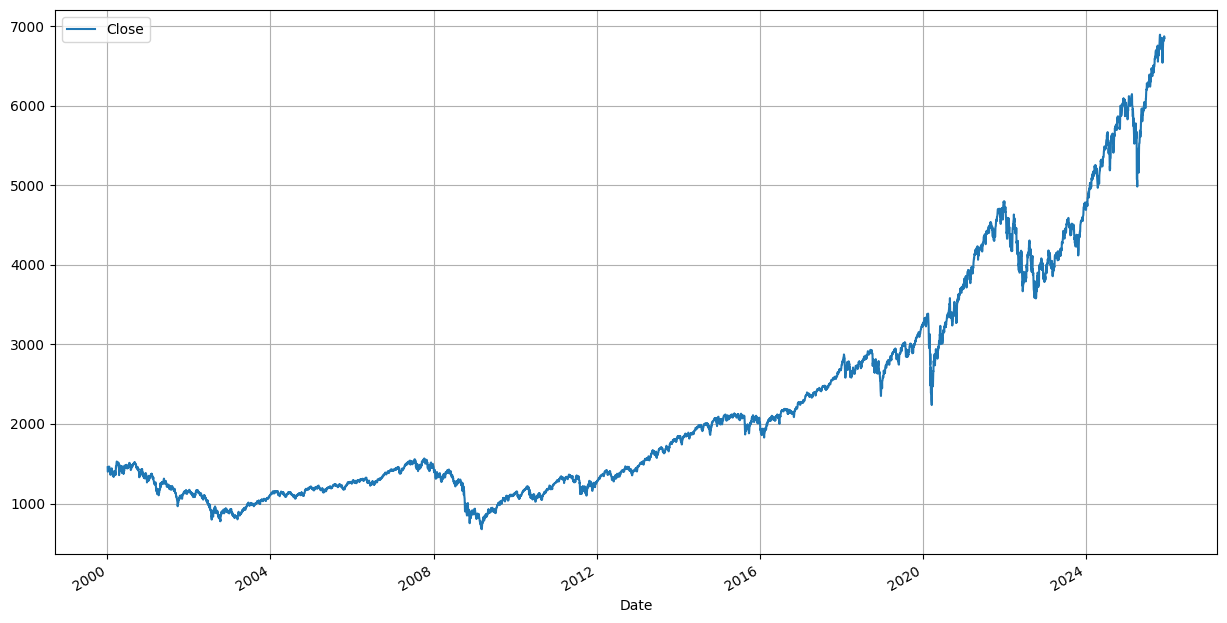

In [14]:
evol_data = pd.concat([df['Date'],df['Close']], axis=1)
evol_data = evol_data.set_index(['Date'])
evol_data.plot(figsize=(15,8), grid = True)

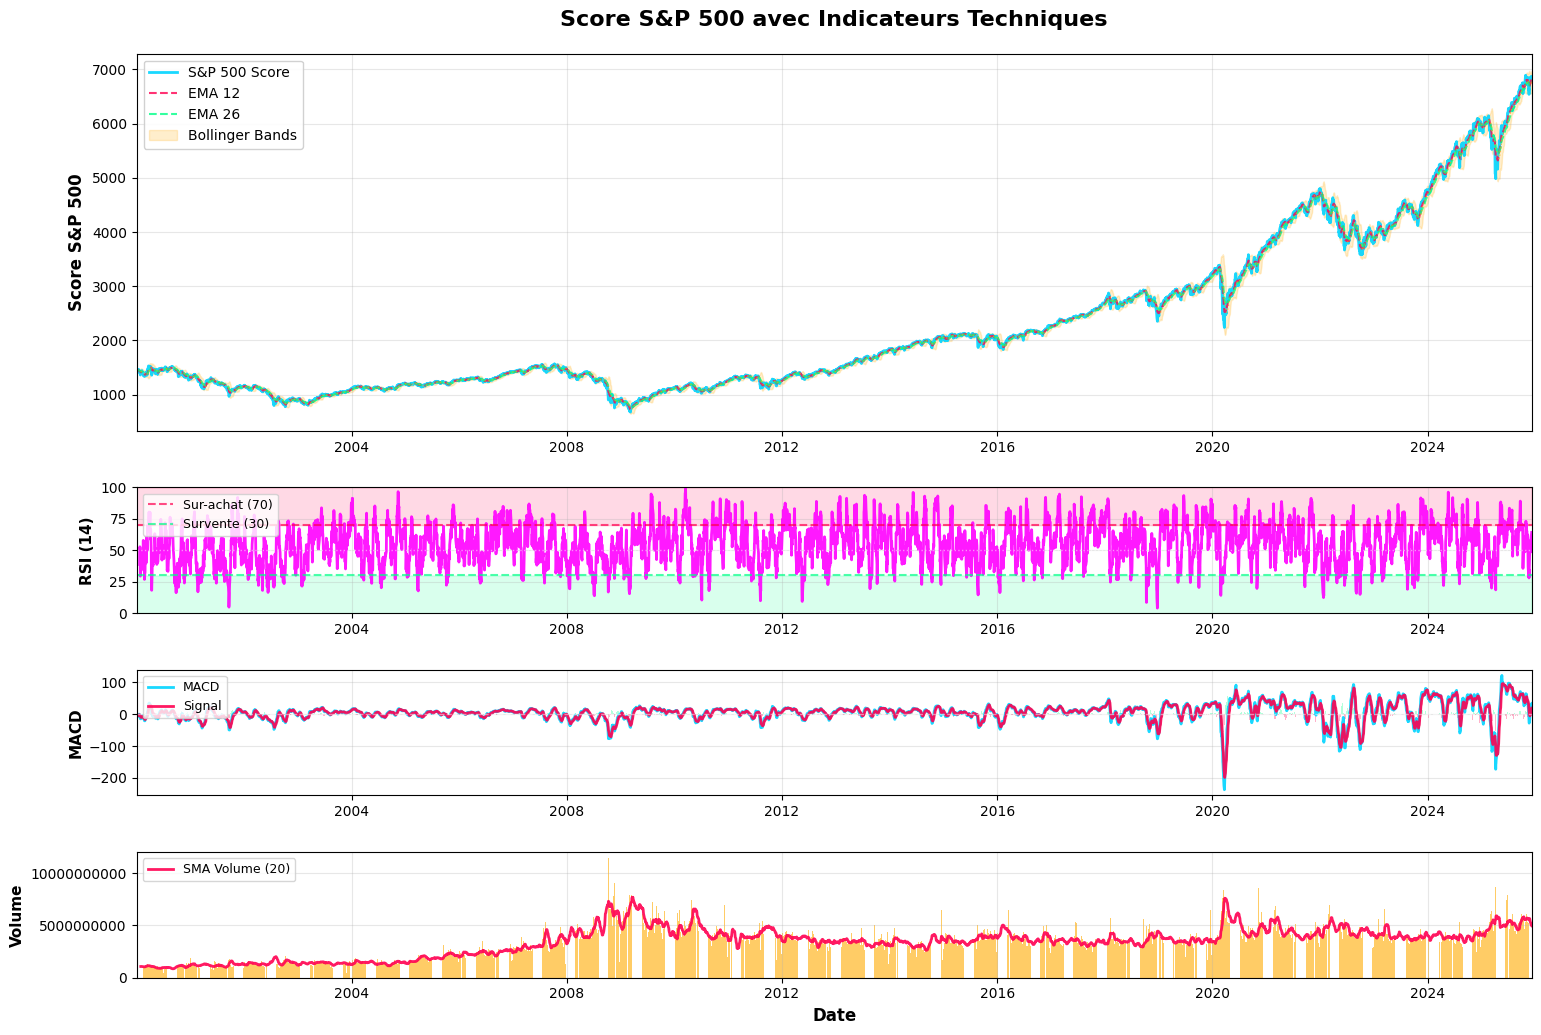

In [20]:
fig1 = plt.figure(figsize=(18, 12))
gs = fig1.add_gridspec(4, 1, height_ratios=[3, 1, 1, 1], hspace=0.3)

# Subplot 1: Score Close avec EMA et Bollinger Bands
ax1 = fig1.add_subplot(gs[0])
ax1.plot(df['Date'], df['Close'], label='S&P 500 Score', 
         linewidth=2, color='#00d4ff', alpha=0.9)
ax1.plot(df['Date'], df['EMA_12'], label='EMA 12', 
         linewidth=1.5, color='#ff0051', alpha=0.8, linestyle='--')
ax1.plot(df['Date'], df['EMA_26'], label='EMA 26', 
         linewidth=1.5, color='#00ff88', alpha=0.8, linestyle='--')

# Bollinger Bands
ax1.fill_between(df['Date'], df['BB_Upper'], df['BB_Lower'], 
                  alpha=0.2, color='#ffaa00', label='Bollinger Bands')
ax1.plot(df['Date'], df['BB_Mid'], linewidth=1, 
         color='#ffaa00', alpha=0.6, linestyle=':')

ax1.set_ylabel('Score S&P 500', fontsize=12, fontweight='bold')
ax1.set_title('Score S&P 500 avec Indicateurs Techniques', fontsize=16, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(alpha=0.3)
ax1.set_xlim(df['Date'].min(), df['Date'].max())

# Subplot 2: RSI
ax2 = fig1.add_subplot(gs[1], sharex=ax1)
ax2.plot(df['Date'], df['RSI_14'], linewidth=2, color='#ff00ff', alpha=0.9)
ax2.axhline(70, color='#ff0051', linestyle='--', linewidth=1.5, alpha=0.7, label='Sur-achat (70)')
ax2.axhline(30, color='#00ff88', linestyle='--', linewidth=1.5, alpha=0.7, label='Survente (30)')
ax2.axhline(50, color='white', linestyle=':', linewidth=1, alpha=0.5)
ax2.fill_between(df['Date'], 70, 100, alpha=0.15, color='#ff0051')
ax2.fill_between(df['Date'], 0, 30, alpha=0.15, color='#00ff88')
ax2.set_ylabel('RSI (14)', fontsize=11, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)

# Subplot 3: MACD
ax3 = fig1.add_subplot(gs[2], sharex=ax1)
ax3.plot(df['Date'], df['MACD'], linewidth=2, color='#00d4ff', 
         alpha=0.9, label='MACD')
ax3.plot(df['Date'], df['MACD_signal'], linewidth=2, color='#ff0051', 
         alpha=0.9, label='Signal')
ax3.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5)
# Histogramme MACD
macd_hist = df['MACD'] - df['MACD_signal']
colors = ['#00ff88' if x > 0 else '#ff0051' for x in macd_hist]
ax3.bar(df['Date'], macd_hist, width=1, alpha=0.3, color=colors)
ax3.set_ylabel('MACD', fontsize=11, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(alpha=0.3)

# Subplot 4: Volume
ax4 = fig1.add_subplot(gs[3], sharex=ax1)
ax4.bar(df['Date'], df['Volume'], width=1, alpha=0.6, color='#ffaa00')
ax4.plot(df['Date'], df['Volume_SMA20'], linewidth=2, 
         color='#ff0051', alpha=0.9, label='SMA Volume (20)')
ax4.set_ylabel('Volume', fontsize=11, fontweight='bold')
ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(alpha=0.3)
ax4.ticklabel_format(style='plain', axis='y')
plt.show()
plt.tight_layout()
plt.close()


📈 2/7 - RSI détaillé...


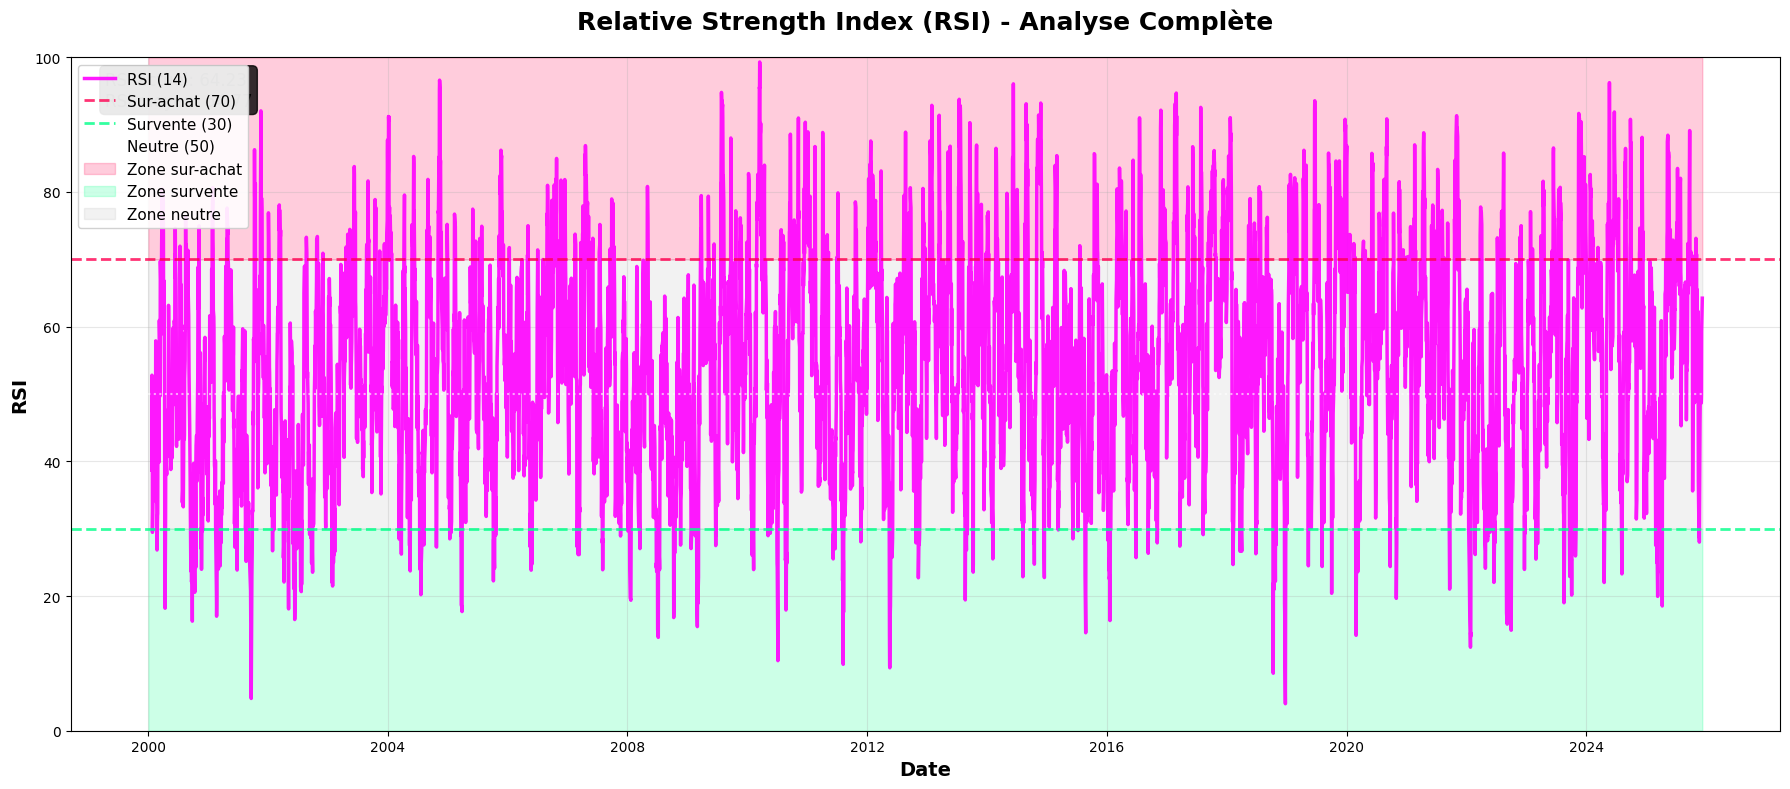

In [21]:
# ==============================================================================
# GRAPHIQUE 2: RSI DÉTAILLÉ
# ==============================================================================
print("📈 2/7 - RSI détaillé...")
fig2, ax = plt.subplots(figsize=(18, 8))

ax.plot(df['Date'], df['RSI_14'], linewidth=2.5, color='#ff00ff', alpha=0.9, label='RSI (14)')
ax.axhline(70, color='#ff0051', linestyle='--', linewidth=2, alpha=0.8, label='Sur-achat (70)')
ax.axhline(30, color='#00ff88', linestyle='--', linewidth=2, alpha=0.8, label='Survente (30)')
ax.axhline(50, color='white', linestyle=':', linewidth=1.5, alpha=0.6, label='Neutre (50)')

# Zones colorées
ax.fill_between(df['Date'], 70, 100, alpha=0.2, color='#ff0051', label='Zone sur-achat')
ax.fill_between(df['Date'], 0, 30, alpha=0.2, color='#00ff88', label='Zone survente')
ax.fill_between(df['Date'], 30, 70, alpha=0.1, color='gray', label='Zone neutre')

ax.set_ylabel('RSI', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_title('Relative Strength Index (RSI) - Analyse Complète', fontsize=18, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3)

# Statistiques RSI
rsi_mean = df['RSI_14'].mean()
rsi_current = df['RSI_14'].iloc[-1]
ax.text(0.02, 0.98, f'RSI actuel: {rsi_current:.2f}\nRSI moyen: {rsi_mean:.2f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

plt.tight_layout()
plt.show()
plt.close()

🚀 3/7 - Analyse des Momentum...


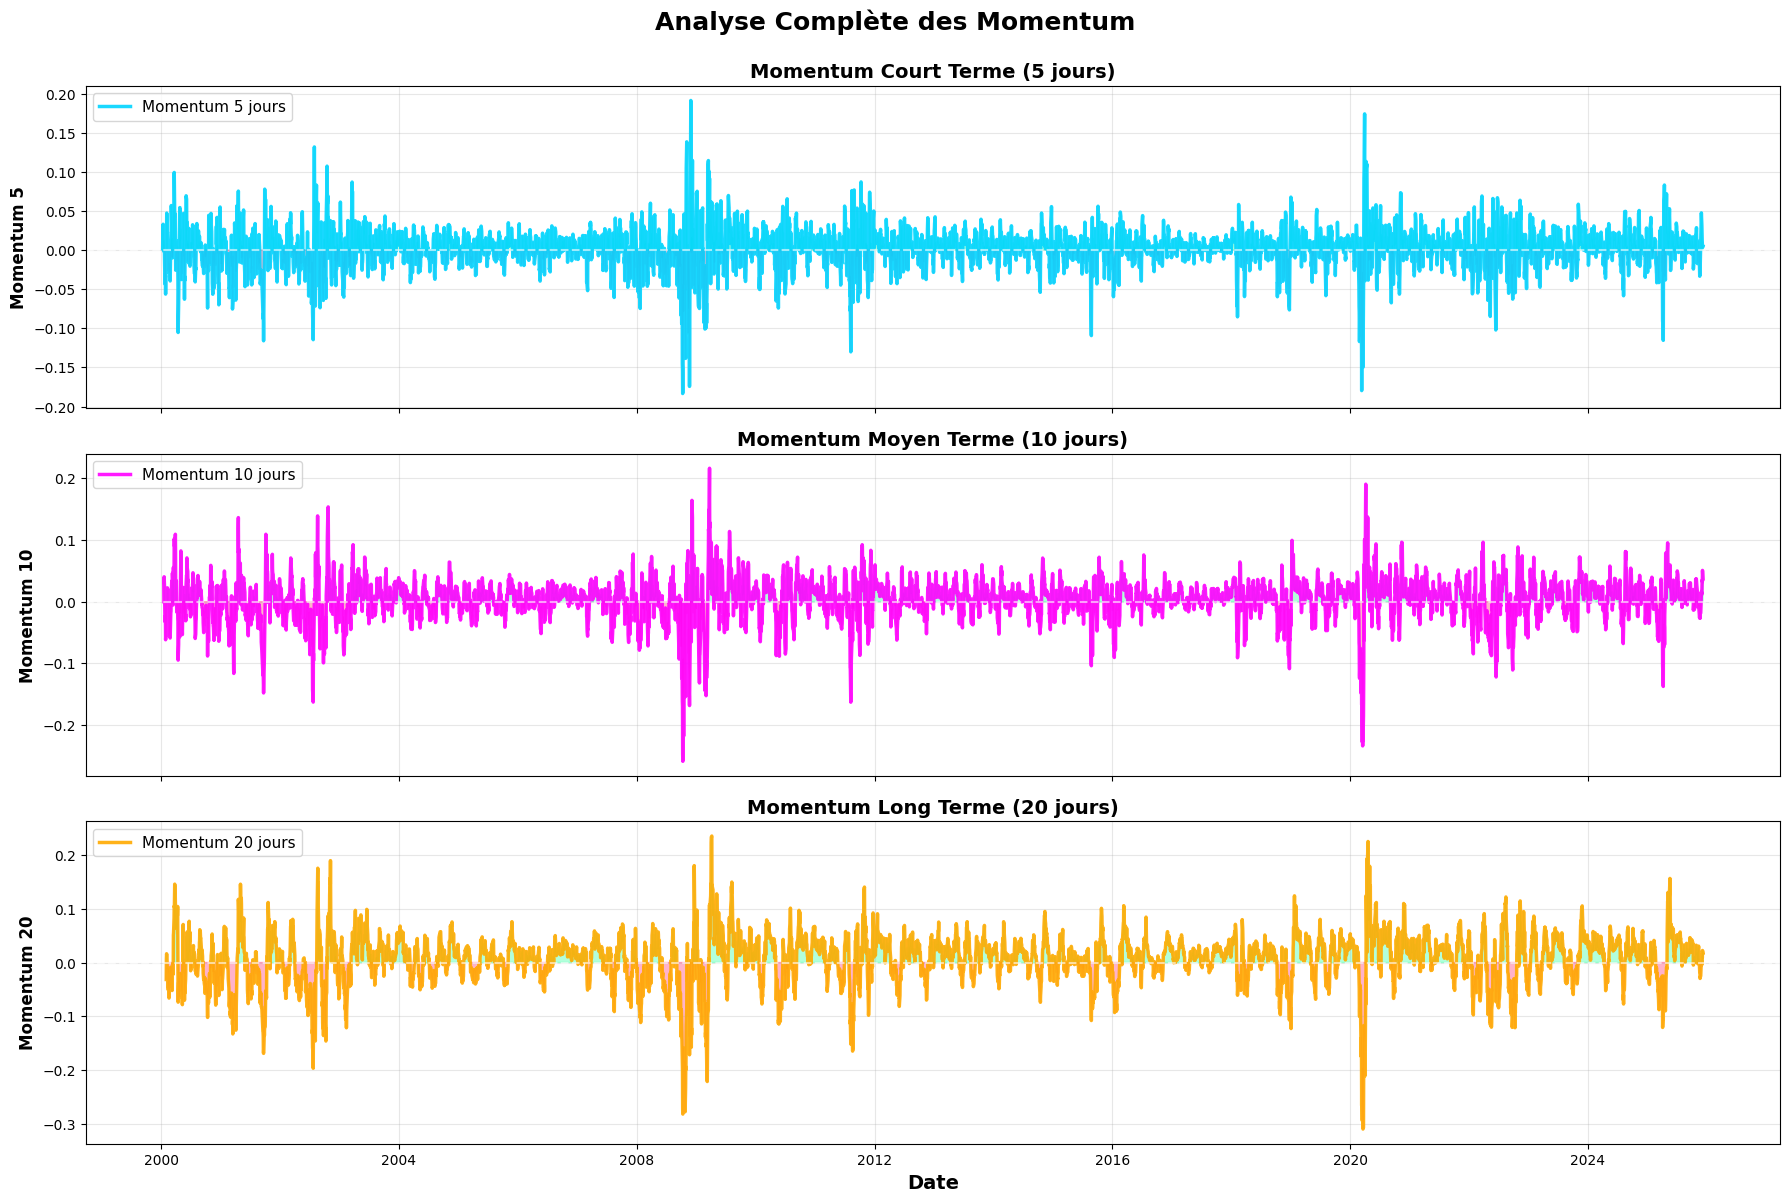

In [22]:
# ==============================================================================
# GRAPHIQUE 3: MOMENTUM (5, 10, 20 jours)
# ==============================================================================
print("🚀 3/7 - Analyse des Momentum...")
fig3, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

# Momentum 5
axes[0].plot(df['Date'], df['Momentum_5'], linewidth=2.5, 
             color='#00d4ff', alpha=0.9, label='Momentum 5 jours')
axes[0].axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.6)
axes[0].fill_between(df['Date'], df['Momentum_5'], 0, 
                      where=(df['Momentum_5'] > 0), alpha=0.3, color='#00ff88', interpolate=True)
axes[0].fill_between(df['Date'], df['Momentum_5'], 0, 
                      where=(df['Momentum_5'] <= 0), alpha=0.3, color='#ff0051', interpolate=True)
axes[0].set_ylabel('Momentum 5', fontsize=12, fontweight='bold')
axes[0].set_title('Momentum Court Terme (5 jours)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(alpha=0.3)

# Momentum 10
axes[1].plot(df['Date'], df['Momentum_10'], linewidth=2.5, 
             color='#ff00ff', alpha=0.9, label='Momentum 10 jours')
axes[1].axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.6)
axes[1].fill_between(df['Date'], df['Momentum_10'], 0, 
                      where=(df['Momentum_10'] > 0), alpha=0.3, color='#00ff88', interpolate=True)
axes[1].fill_between(df['Date'], df['Momentum_10'], 0, 
                      where=(df['Momentum_10'] <= 0), alpha=0.3, color='#ff0051', interpolate=True)
axes[1].set_ylabel('Momentum 10', fontsize=12, fontweight='bold')
axes[1].set_title('Momentum Moyen Terme (10 jours)', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(alpha=0.3)

# Momentum 20
axes[2].plot(df['Date'], df['Momentum_20'], linewidth=2.5, 
             color='#ffaa00', alpha=0.9, label='Momentum 20 jours')
axes[2].axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.6)
axes[2].fill_between(df['Date'], df['Momentum_20'], 0, 
                      where=(df['Momentum_20'] > 0), alpha=0.3, color='#00ff88', interpolate=True)
axes[2].fill_between(df['Date'], df['Momentum_20'], 0, 
                      where=(df['Momentum_20'] <= 0), alpha=0.3, color='#ff0051', interpolate=True)
axes[2].set_ylabel('Momentum 20', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=14, fontweight='bold')
axes[2].set_title('Momentum Long Terme (20 jours)', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=11)
axes[2].grid(alpha=0.3)

fig3.suptitle('Analyse Complète des Momentum', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()
plt.close()

📉 4/7 - Analyse de la Volatilité...


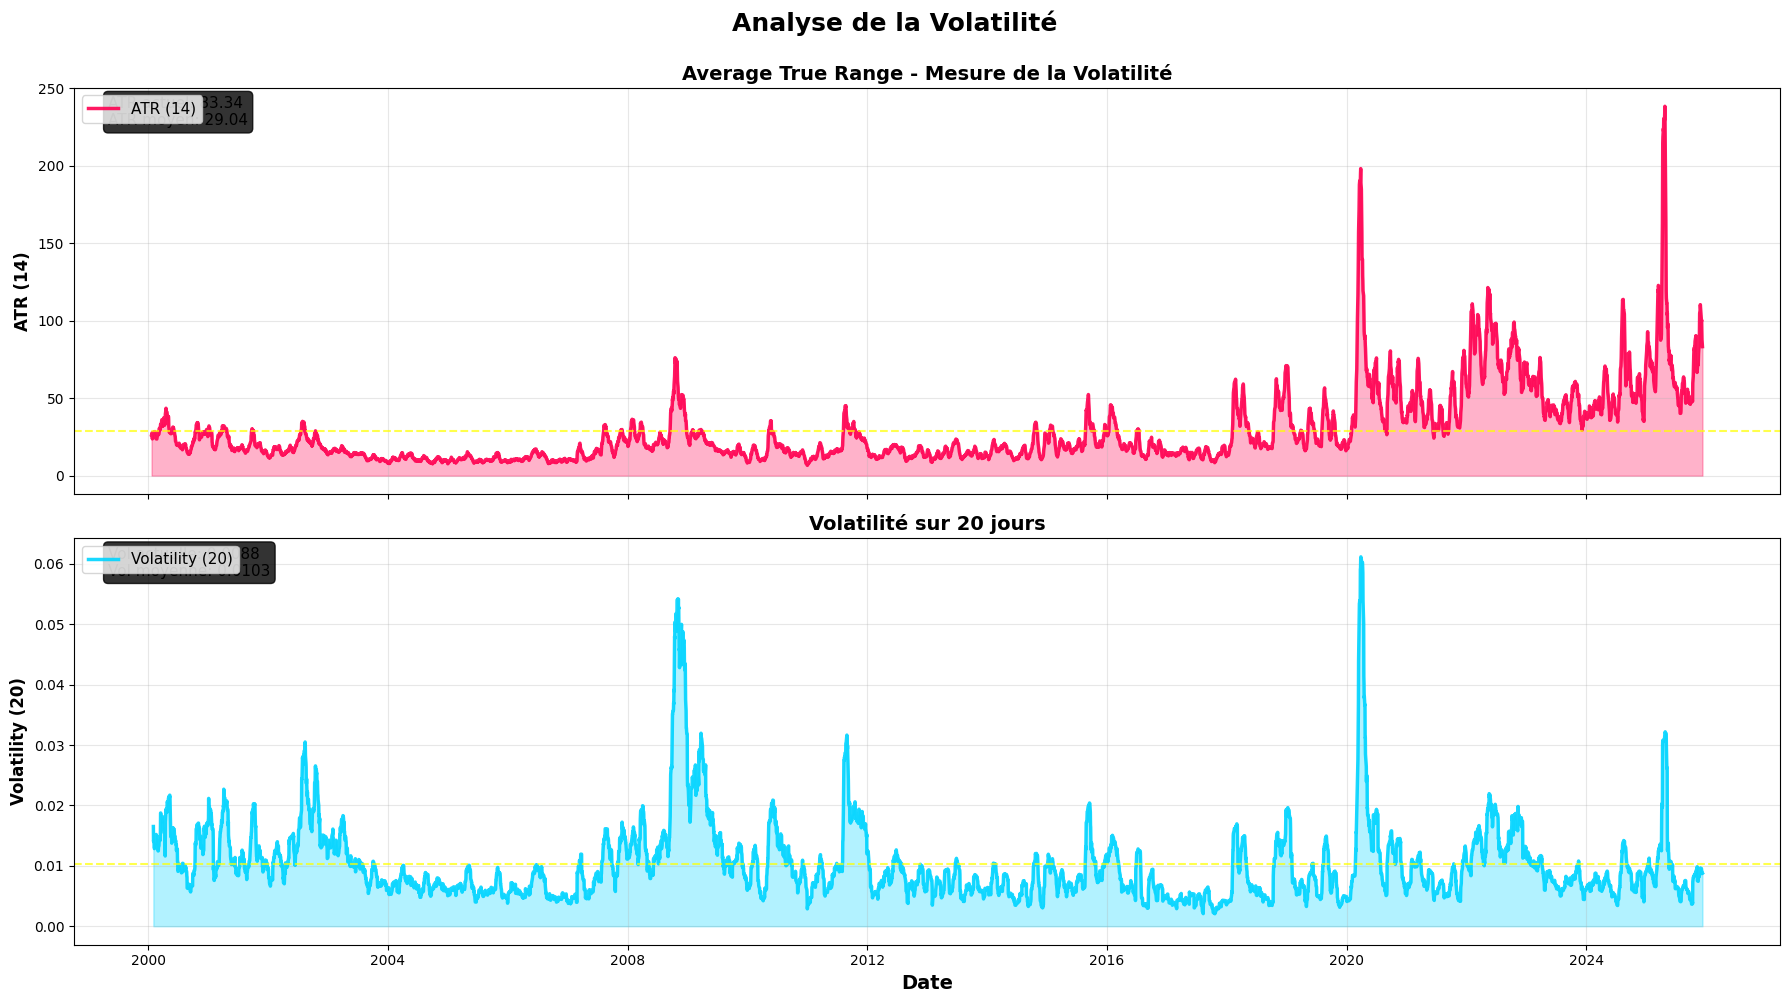

In [26]:
# ==============================================================================
# GRAPHIQUE 4: VOLATILITÉ (ATR + Volatility)
# ==============================================================================
print("📉 4/7 - Analyse de la Volatilité...")
fig4, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# ATR
axes[0].plot(df['Date'], df['ATR_14'], linewidth=2.5, 
             color='#ff0051', alpha=0.9, label='ATR (14)')
axes[0].fill_between(df['Date'], df['ATR_14'], alpha=0.3, color='#ff0051')
axes[0].set_ylabel('ATR (14)', fontsize=12, fontweight='bold')
axes[0].set_title('Average True Range - Mesure de la Volatilité', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(alpha=0.3)

# Statistiques ATR
atr_mean = df['ATR_14'].mean()
atr_current = df['ATR_14'].iloc[-1]
axes[0].axhline(atr_mean, color='yellow', linestyle='--', linewidth=1.5, alpha=0.7, label=f'ATR moyen: {atr_mean:.2f}')
axes[0].text(0.02, 0.98, f'ATR actuel: {atr_current:.2f}\nATR moyen: {atr_mean:.2f}', 
             transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

# Volatility 20
axes[1].plot(df['Date'], df['Volatility_20'], linewidth=2.5, 
             color='#00d4ff', alpha=0.9, label='Volatility (20)')
axes[1].fill_between(df['Date'], df['Volatility_20'], alpha=0.3, color='#00d4ff')
axes[1].set_ylabel('Volatility (20)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=14, fontweight='bold')
axes[1].set_title('Volatilité sur 20 jours', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(alpha=0.3)

# Statistiques Volatility
vol_mean = df['Volatility_20'].mean()
vol_current = df['Volatility_20'].iloc[-1]
axes[1].axhline(vol_mean, color='yellow', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Vol moyen: {vol_mean:.4f}')
axes[1].text(0.02, 0.98, f'Vol actuelle: {vol_current:.4f}\nVol moyenne: {vol_mean:.4f}', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

fig4.suptitle('Analyse de la Volatilité', fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()
plt.close()

🔥 5/7 - Matrice de corrélation...


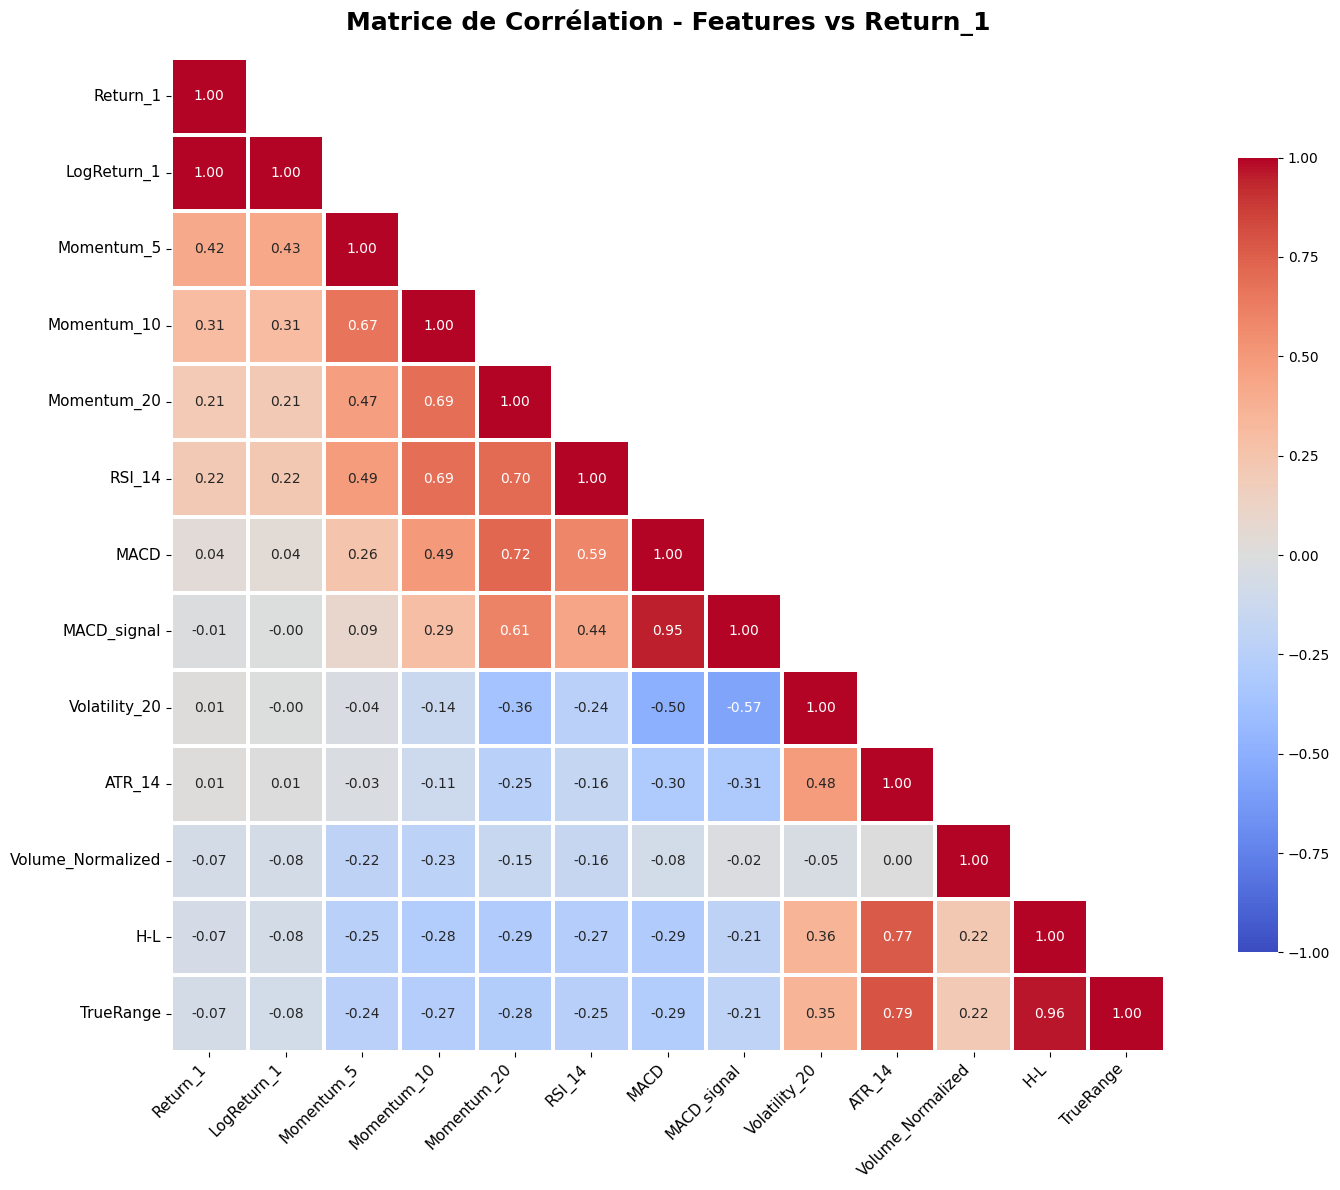

In [27]:
# ==============================================================================
# GRAPHIQUE 5: MATRICE DE CORRÉLATION
# ==============================================================================
print("🔥 5/7 - Matrice de corrélation...")
fig5, ax5 = plt.subplots(figsize=(16, 12))

features = ['Return_1', 'LogReturn_1', 'Momentum_5', 'Momentum_10', 'Momentum_20', 
            'RSI_14', 'MACD', 'MACD_signal', 'Volatility_20', 'ATR_14', 
            'Volume_Normalized', 'H-L', 'TrueRange']

corr_matrix = df[features].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax5, annot_kws={'size': 10})

ax5.set_title('Matrice de Corrélation - Features vs Return_1', 
              fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()
plt.close()

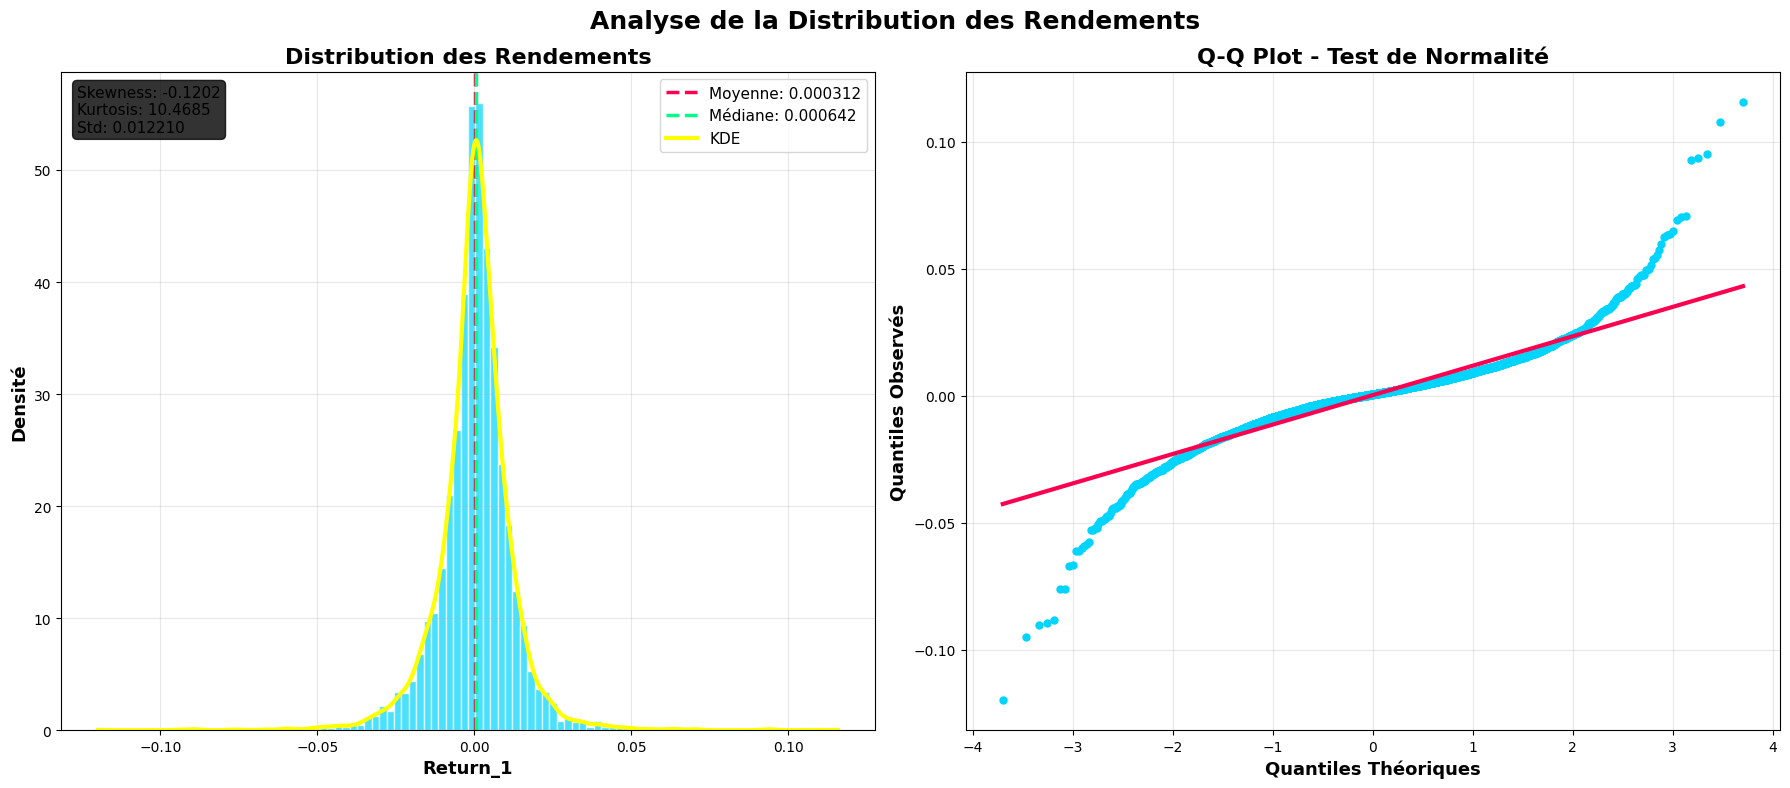

In [32]:
fig6, axes = plt.subplots(1, 2, figsize=(18, 8))

returns = df['Return_1'].dropna()

# Histogramme avec KDE
axes[0].hist(returns, bins=100, alpha=0.7, color='#00d4ff', edgecolor='white', density=True)
axes[0].axvline(returns.mean(), color='#ff0051', linestyle='--', linewidth=2.5, 
                label=f'Moyenne: {returns.mean():.6f}')
axes[0].axvline(returns.median(), color='#00ff88', linestyle='--', linewidth=2.5, 
                label=f'Médiane: {returns.median():.6f}')

# KDE overlay
from scipy.stats import gaussian_kde
kde = gaussian_kde(returns)
x_range = np.linspace(returns.min(), returns.max(), 1000)
axes[0].plot(x_range, kde(x_range), color='yellow', linewidth=3, label='KDE')

axes[0].set_xlabel('Return_1', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Densité', fontsize=13, fontweight='bold')
axes[0].set_title('Distribution des Rendements', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Statistiques
skew = stats.skew(returns)
kurt = stats.kurtosis(returns)
axes[0].text(0.02, 0.98, f'Skewness: {skew:.4f}\nKurtosis: {kurt:.4f}\nStd: {returns.std():.6f}', 
             transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

# Q-Q Plot
stats.probplot(returns, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_color('#00d4ff')
axes[1].get_lines()[0].set_markersize(5)
axes[1].get_lines()[1].set_color('#ff0051')
axes[1].get_lines()[1].set_linewidth(3)
axes[1].set_title('Q-Q Plot - Test de Normalité', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Quantiles Théoriques', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Quantiles Observés', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

fig6.suptitle('Analyse de la Distribution des Rendements', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()
plt.close()

🎯 7/7 - Autocorrélation (ACF/PACF)...


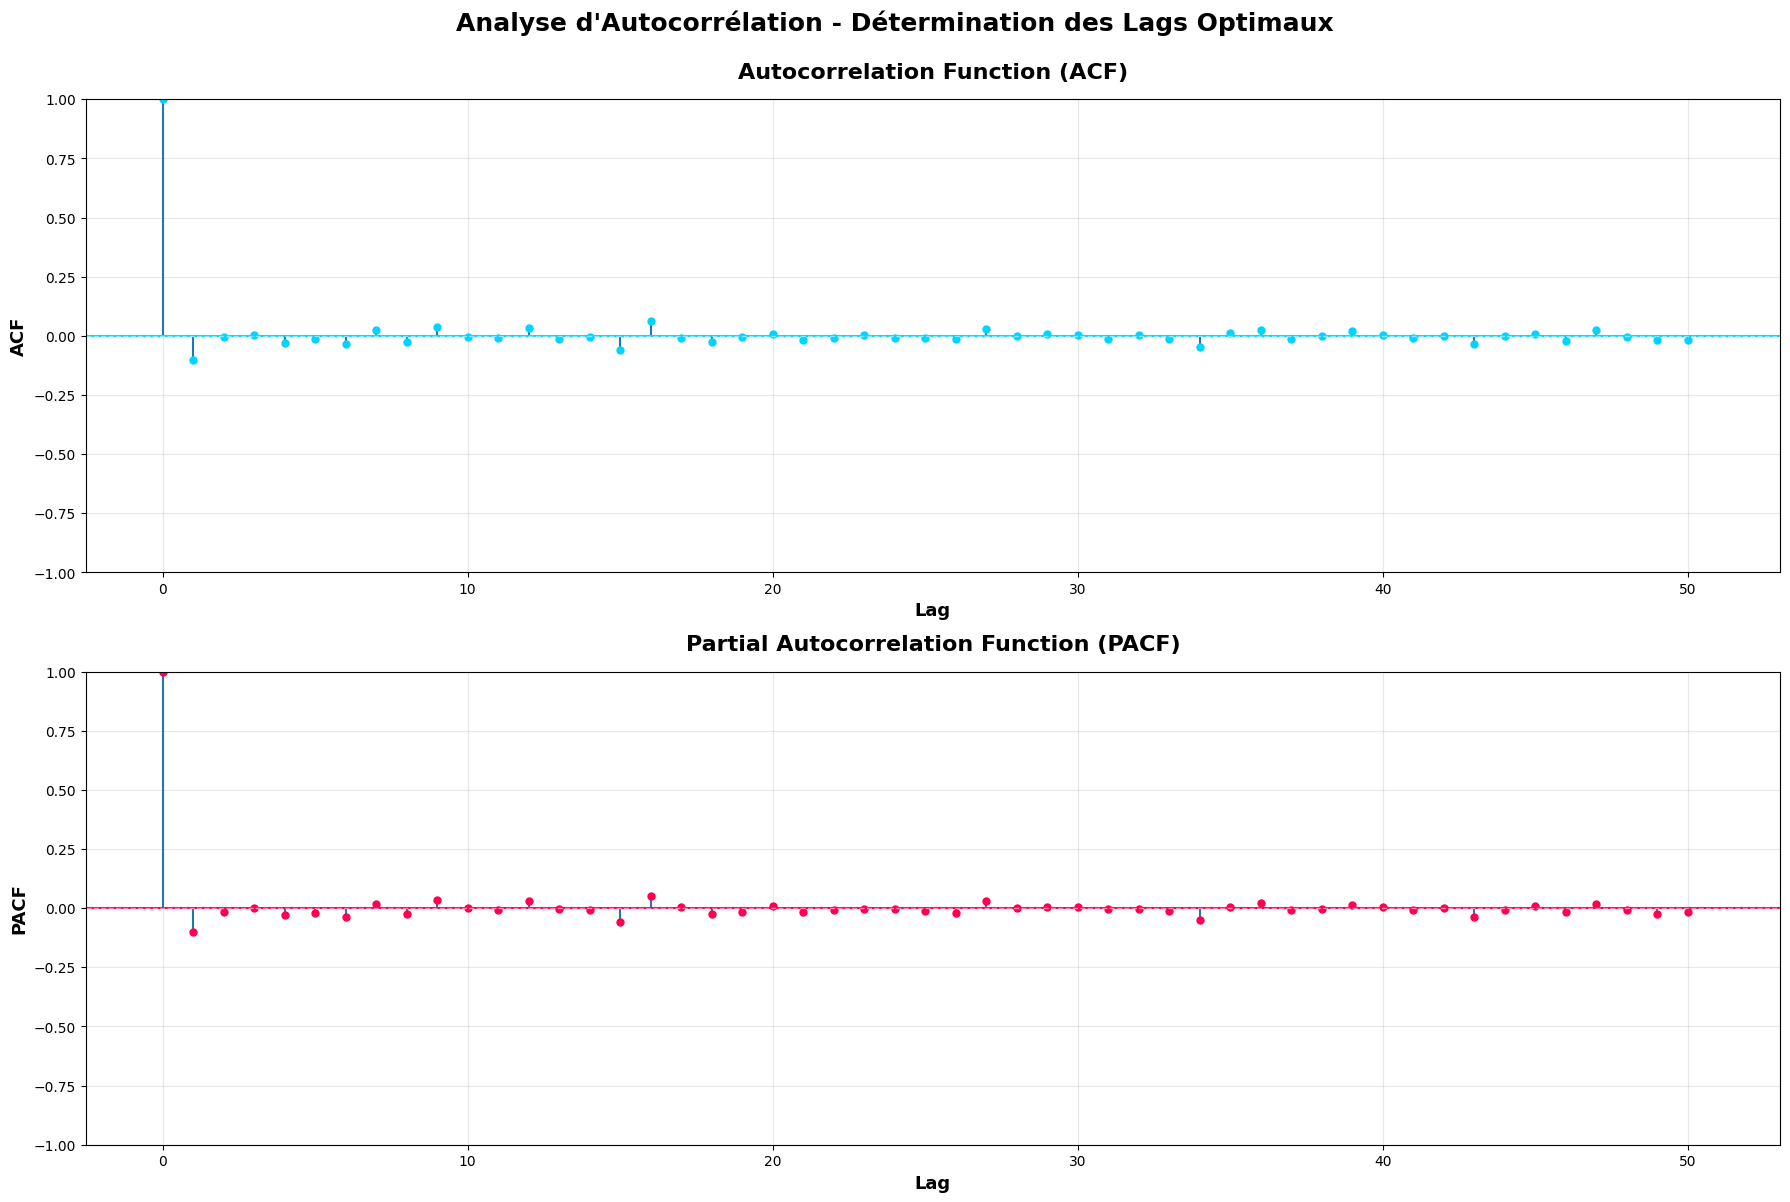

In [33]:
# ==============================================================================
# GRAPHIQUE 7: AUTOCORRÉLATION (ACF + PACF)
# ==============================================================================
print("🎯 7/7 - Autocorrélation (ACF/PACF)...")
fig7, axes = plt.subplots(2, 1, figsize=(18, 12))

returns_clean = df['Return_1'].dropna()

# ACF
plot_acf(returns_clean, lags=50, ax=axes[0], color='#00d4ff', alpha=0.8)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Lag', fontsize=13, fontweight='bold')
axes[0].set_ylabel('ACF', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5)

# PACF
plot_pacf(returns_clean, lags=50, ax=axes[1], color='#ff0051', alpha=0.8)
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Lag', fontsize=13, fontweight='bold')
axes[1].set_ylabel('PACF', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.5)

fig7.suptitle('Analyse d\'Autocorrélation - Détermination des Lags Optimaux', 
              fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()
plt.close()

In [34]:
# ==============================================================================
# RÉSUMÉ STATISTIQUE
# ==============================================================================
print("\n" + "="*80)
print("📊 RÉSUMÉ DE L'ANALYSE S&P 500")
print("="*80)

print(f"\n📅 Période analysée: {df['Date'].min().date()} à {df['Date'].max().date()}")
print(f"📈 Nombre de jours: {len(df)}")
print(f"\n💰 SCORE S&P 500:")
print(f"  Actuel: {df['Close'].iloc[-1]:.2f}")
print(f"  Minimum: {df['Close'].min():.2f} ({df[df['Close'] == df['Close'].min()]['Date'].iloc[0].date()})")
print(f"  Maximum: {df['Close'].max():.2f} ({df[df['Close'] == df['Close'].max()]['Date'].iloc[0].date()})")
print(f"  Variation totale: {((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0] * 100):.2f}%")

print("\n💹 RENDEMENTS:")
print(f"  Moyenne: {returns.mean():.6f} ({returns.mean()*100:.4f}% par jour)")
print(f"  Médiane: {returns.median():.6f}")
print(f"  Écart-type: {returns.std():.6f}")
print(f"  Skewness: {skew:.4f} {'(asymétrie négative)' if skew < 0 else '(asymétrie positive)'}")
print(f"  Kurtosis: {kurt:.4f} {'(queues épaisses)' if kurt > 0 else '(queues fines)'}")
print(f"  Min: {returns.min():.6f} ({returns.min()*100:.4f}%)")
print(f"  Max: {returns.max():.6f} ({returns.max()*100:.4f}%)")

print("\n📉 RSI (14):")
rsi_current = df['RSI_14'].iloc[-1]
rsi_mean = df['RSI_14'].mean()
print(f"  Valeur actuelle: {rsi_current:.2f}")
print(f"  Moyenne: {rsi_mean:.2f}")
if rsi_current > 70:
    print("  ⚠️  SIGNAL: SUR-ACHAT")
elif rsi_current < 30:
    print("  ⚠️  SIGNAL: SURVENTE")
else:
    print("  ✓ ZONE NEUTRE")

print("\n🚀 MOMENTUM:")
print(f"  Momentum 5j: {df['Momentum_5'].iloc[-1]:.6f}")
print(f"  Momentum 10j: {df['Momentum_10'].iloc[-1]:.6f}")
print(f"  Momentum 20j: {df['Momentum_20'].iloc[-1]:.6f}")

print("\n📊 VOLATILITÉ:")
print(f"  ATR (14): {df['ATR_14'].iloc[-1]:.2f} (moyenne: {df['ATR_14'].mean():.2f})")
print(f"  Volatility (20): {df['Volatility_20'].iloc[-1]:.6f} (moyenne: {df['Volatility_20'].mean():.6f})")

print("\n🎯 TOP 5 CORRÉLATIONS AVEC RETURN_1:")
corr_with_target = corr_matrix['Return_1'].drop('Return_1').abs().sort_values(ascending=False)
for i, (feat, corr_val) in enumerate(corr_with_target.head(5).items(), 1):
    original_corr = corr_matrix['Return_1'][feat]
    print(f"  {i}. {feat}: {original_corr:+.4f}")



📊 RÉSUMÉ DE L'ANALYSE S&P 500

📅 Période analysée: 2000-01-03 à 2025-12-08
📈 Nombre de jours: 6523

💰 SCORE S&P 500:
  Actuel: 6846.51
  Minimum: 676.53 (2009-03-09)
  Maximum: 6890.89 (2025-10-28)
  Variation totale: 370.48%

💹 RENDEMENTS:
  Moyenne: 0.000312 (0.0312% par jour)
  Médiane: 0.000642
  Écart-type: 0.012210
  Skewness: -0.1202 (asymétrie négative)
  Kurtosis: 10.4685 (queues épaisses)
  Min: -0.119841 (-11.9841%)
  Max: 0.115800 (11.5800%)

📉 RSI (14):
  Valeur actuelle: 64.23
  Moyenne: 54.77
  ✓ ZONE NEUTRE

🚀 MOMENTUM:
  Momentum 5j: 0.004973
  Momentum 10j: 0.036880
  Momentum 20j: 0.017493

📊 VOLATILITÉ:
  ATR (14): 83.34 (moyenne: 29.04)
  Volatility (20): 0.008775 (moyenne: 0.010306)

🎯 TOP 5 CORRÉLATIONS AVEC RETURN_1:
  1. LogReturn_1: +0.9998
  2. Momentum_5: +0.4217
  3. Momentum_10: +0.3056
  4. RSI_14: +0.2154
  5. Momentum_20: +0.2072
